# TODO
* Do ITIs depend on _previous_ trial somehow? 
* Hierarchical fitting (with or without RTs)
    * Baseline model: $\theta \sim 1$ (just regular group-level priors)
    * Age group differences: $\theta \sim agegroup$ (two groups based on agegroup)
    * Meta-learning: $\theta \sim session$ (linear effect of session? quadratic?)
    * Age group and meta-learning: $\theta \sim session + agegroup$ (how do I specify within- vs between-participant factors? {session vs agegroup)
    * Differences in meta-learning based on agegroup: $\theta \sim session \times agegroup$
    * Model comparison using WAIC

## In progress


## Done
* DONE Run RL models on new, clean data
    * DONE Exclude for 10 sessiosn and 500 trials
    * DONE Make sure I'm doing everything I'm doing in the notebook
    * DONE Could I just use true_dat?
* DONE Plot results using old notebook
* CHECK Split pre-processing into separate notebook
* CHECK Basic RT plots
    * CHECK RT over sessions, blocks, trials
    * CHECK RT differences reward vs no-reward; correct vs incorrect
* CHECK RT regression model
    * DONE choice ~ prev_choice + prev_reward + prev_RT
    * DONE run hierarchical
* CHECK Add RTs into model
    * CHECK Avoid NaNs in RL model -> Remove fast RTs earlier by shifting up trials
    * CHECK Calculate an RT modulator rta (for $\alpha$) or rtb (for $\beta$) 
        * will be multiplied with $\alpha$ / $\beta$
        * is 1 when parameter is not set; is RT * parameter otherwise
        * needs to be [0, 1]
    * CHECK Figure out why it's not working... 
        * CHECK Why can't I print rta, rtb, or any parameter at all any more?
        * 
    * Modulates alpha? -> dopamine = RPE
    * Modulates beta? -> dopamine = response vigor
* CHECK Is the RT model better than the no-RT model? -> Plot (W)AIC etc.

I think you ran the best model for visualization. To test statistical significance, I think it might be good to run a model like `action ~ reward * noreward * n_ago * rt_quartile`, i.e., instead of having reward_1ago_rtquart0, reward_2ago_rtquart0, reward_1ago_rtquart1, reward_2ago_rtquart1, noreward_1ago_rtquart0, noreward_2ago_rtquart0, etc. etc., we'd have just four predictors: One for reward, one for noreward, one for n_ago, and one for RT quartile. This way we could test the effect of just reward (should be positive, i.e., mice should be more likely to select rewarded actions again), just noreward (should be negative), just rt_quartile (should have no main effect), and just n_ago (also no main effect). Then we'd expect interactions between n_ago and reward/noreward (showing that the effect of reward and noreward decays with delay), between rt_quartiles, and reward/noreward (showing that the effects of reward/noreward differ based on RTs), and potentially a triple interaction between rt_quartiles, n_ago, and reward/noreward (showing that the effect of 

I think there is a better way to run this model by splitting reward, noreward, and n_ago into separate regressors. This way we could test the overall effect of reward (should be positive) and of noreward (should be negative), and interactions between reward/noreward and n_ago (should be negative, showing that the effects of reward and noreward decay with delay), and between reward/noreward and rt_quartiles (should also be negative, showing that the effects of reward / noreward decrease with longer RTs). We could even treat RTs as a continuous variable, rather than splitting it into arbitrary groups, and for extra power.

In [ ]:
(gg.ggplot(true_dat, gg.aes('rt'))
 + gg.geom_histogram()
)

In [ ]:
true_dat['log_rt'] = np.log(true_dat.rt)
(gg.ggplot(true_dat, gg.aes('log_rt'))
 + gg.geom_histogram()
)

In [ ]:
dat = pd.DataFrame({'raw_rt': true_dat.rt, 'log_rt': np.log(true_dat.rt)})
dat
(gg.ggplot(dat, gg.aes('raw_rt', 'log_rt'))
 + gg.geom_point()
)

# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import statsmodels.formula.api as smf

from Functions import get_info_from_fullID, add_meta_column, sigmoid, get_session

In [2]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
# save_or_load_true_mouse_dat = 'load'  # 'save', 'load'
# save_or_load_sim_mouse_dat = 'save'  # 'save', 'load'
n_trial_cutoff = 500  # 500 as of 2020/07/21
n_session_cutoff = 10  # 10 as of 2020/07/21
# rt_cut_off = 10  # 10 seconds as of 2020/07/29

# Get cleaned mouse data

In [4]:
true_dat_all = pd.read_csv(os.path.join(mouse_data_dir, 'mouse_true_dat_raw.csv'))
true_dat_all

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,act_18ago,act_19ago,block_length,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,0.0,0.0,0.0,nn,nn,nn,1-3
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,1.0,1.0,0.0,0n,0n,0n,1-3
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,2.0,2.0,0.0,00,00,00,1-3
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,3.0,3.0,0.0,10,10,10,1-3
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,4.0,4.0,0.0,11,11,11,1-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350164,NaN,NaN,NaN,NaN,768,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
350165,NaN,NaN,NaN,NaN,769,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
350166,NaN,NaN,NaN,NaN,770,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
350167,NaN,NaN,NaN,NaN,771,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,NaN,NaN,15.0,nn,nn,nn,NaN


In [5]:
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'true_dat.csv'))
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,act_19ago,block_length,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta,excluded
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,0.0,0.0,0.0,nn,nn,nn,1-3,False
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,1.0,1.0,0.0,0n,0n,0n,1-3,False
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,2.0,2.0,0.0,00,00,00,1-3,False
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,3.0,3.0,0.0,10,10,10,1-3,False
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,4.0,4.0,0.0,11,11,11,1-3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191495,0.0,0.0,3.70600,0.0,495,26.0,1308321,Adult,Female,83,...,0.0,25.0,2.0,2.0,10.0,00,10,10,9-11,False
191496,0.0,0.0,1.91100,0.0,496,26.0,1308321,Adult,Female,83,...,0.0,25.0,3.0,3.0,10.0,00,01,01,9-11,False
191497,1.0,1.0,3.54000,1.0,497,26.0,1308321,Adult,Female,83,...,1.0,25.0,4.0,4.0,10.0,00,00,00,9-11,False
191498,1.0,0.0,0.52400,1.0,498,26.0,1308321,Adult,Female,83,...,0.0,25.0,5.0,5.0,10.0,10,10,10,9-11,False


In [6]:
# Make agegroup and sex ordered categorical columns
true_dat['agegroup'] = pd.Categorical(true_dat.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat['sex'] = pd.Categorical(true_dat.sex, categories=('Male', 'Female'), ordered=True)
true_dat_all['agegroup'] = pd.Categorical(true_dat_all.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat_all['sex'] = pd.Categorical(true_dat_all.sex, categories=('Male', 'Female'), ordered=True)

# Run regression models

## Agegroup differences in performance?

In [ ]:
# Summarize data for regression
mean_dat = true_dat.groupby(['fullID']).mean().reset_index()
mean_dat['sex'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Simple model based on mean data (1 data point per mouse per session)
print(smf.ols(
    "correct ~ (session + sex + agegroup) * (session + sex + agegroup)",
    mean_dat,
).fit().summary())

In [ ]:
# Mixed-effects model based on all data (500 trials per animal per session)
# PROBLEM: I WANT TO RUN A LOGIT MODEL, NOT LINEAR REGRESSION; CORRECT IS BINARY
print(smf.mixedlm(
    "correct ~ (block + session + sex + agegroup) * (block + session + sex + agegroup)",
    true_dat,
    groups=true_dat["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

In [ ]:
# from statsmodels.formula.api import logit
# PROBLEM: I WANT TO RUN A MIXED-EFFECTS MODEL, NOT FLAT; TRIALS ARE NESTED WITHIN ANIMALS
print(smf.logit(
    "correct ~ (block + session + sex + agegroup) * (block + session + sex + agegroup)",
    true_dat,
).fit().summary())

In [ ]:
# Post-hoc t-tests
print("\nTesting differences between juveniles and adults:")
for sex in np.unique(mean_dat.sex):
    for meta in np.unique(mean_dat.meta):
        
        sub_dat = mean_dat[(mean_dat.meta == meta) * (mean_dat.sex == sex)]
        t, p = scipy.stats.ttest_ind(
            sub_dat.correct[sub_dat.agegroup == 'Juvenile'],
            sub_dat.correct[sub_dat.agegroup == 'Adult']
        )
        print("\t{}s, sessions {}: t={}, p={}".format(sex, meta, round(t, 1), round(p, 4)))

## Complex model, predicting future chioces from past choice, rewards, and RTs

In [7]:
# Add predictors
for n in range(1, 20):
    
    true_dat['reward_{}ago'.format(n)] = true_dat['rew_{}ago'.format(n)].copy()  # reward => reward = 1; no reward => reward = 0
    true_dat['norew_{}ago'.format(n)] = 1 - true_dat['reward_{}ago'.format(n)]  # reward => norew = 0; no reward => norew = 1
#     true_dat['stay_{}ago'.format(n)] = (true_dat['action'] == true_dat['act_{}ago'.format(n)]).astype(int)  # action now == action then => stay = 1
#     true_dat['switch_{}ago'.format(n)] = (true_dat['action'] != true_dat['act_{}ago'.format(n)]).astype(int)  # switch
    true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'reward_{}ago'.format(n)] *= -1  # reward & action==right => 1; reward & action==left => -1
    true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'norew_{}ago'.format(n)] *= -1  # no reward & action==right => 1; no reward & action==left => -1
#     true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'stay_{}ago'.format(n)] *= -1  # stay & action==right => 1; stay & action left => -1
#     true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'switch_{}ago'.format(n)] *= -1  # stay & action==right => 1; stay & action left => -1

true_dat.action = 2 * true_dat.action - 1  # left action => -1; right action => +1
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,reward_15ago,norew_15ago,reward_16ago,norew_16ago,reward_17ago,norew_17ago,reward_18ago,norew_18ago,reward_19ago,norew_19ago
0,-1.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191495,-1.0,0.0,3.70600,0.0,495,26.0,1308321,Adult,Female,83,...,-1.0,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0,-0.0,-1.0
191496,-1.0,0.0,1.91100,0.0,496,26.0,1308321,Adult,Female,83,...,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0
191497,1.0,1.0,3.54000,1.0,497,26.0,1308321,Adult,Female,83,...,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0,0.0,1.0
191498,1.0,0.0,0.52400,1.0,498,26.0,1308321,Adult,Female,83,...,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0


In [8]:
rt_quartiles = true_dat.rt.quantile([1/4, 1/2, 3/4, 1]).values
true_dat['rt_quart'] = true_dat.rt.apply(lambda x :
                                         0 if x < rt_quartiles[0] else
                                         (1 if x < rt_quartiles[1] else
                                          (2 if x < rt_quartiles[2] else 3)))
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,norew_15ago,reward_16ago,norew_16ago,reward_17ago,norew_17ago,reward_18ago,norew_18ago,reward_19ago,norew_19ago,rt_quart
0,-1.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,-1.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191495,-1.0,0.0,3.70600,0.0,495,26.0,1308321,Adult,Female,83,...,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0,-0.0,-1.0,3
191496,-1.0,0.0,1.91100,0.0,496,26.0,1308321,Adult,Female,83,...,-0.0,-1.0,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0,3
191497,1.0,1.0,3.54000,1.0,497,26.0,1308321,Adult,Female,83,...,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0,0.0,1.0,3
191498,1.0,0.0,0.52400,1.0,498,26.0,1308321,Adult,Female,83,...,-0.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0,2


In [9]:
def mod_fit_to_dataframe(results):
    
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame(
        {"p": pvals,
         "coef": coeff,
         "ci_low": conf_lower,
         "ci_high": conf_higher
        }
    )

    return results_df

# # Example use
# mod_fit_to_dataframe(mod)

In [14]:
# Are ITIs predicted by previous trials?
# all_model_results_raw = pd.DataFrame()

# rew_norew_predictors = '(' + ' + '.join(['reward_{}ago + norew_{}ago'.format(i, i) for i in range(1, 5)]) + ')'
# formula = 'action ~ agegroup * rt * ' + rew_norew_predictors
formula = 'rt ~ act_1ago * (reward_1ago + norew_1ago)'
# formula =  "action ~ reward_1ago + norew_1ago"
print(formula)

mod = smf.mixedlm(
    formula,
    true_dat,
    groups=true_dat['fullID'],
    missing='drop',
).fit()

print(mod.summary())
# mod = smf.logit(formula, sub_dat, ).fit()

# model_results = mod_fit_to_dataframe(mod)
# model_results['fullID'] = fullID
# model_results

rt ~ act_1ago * (reward_1ago + norew_1ago)


KeyboardInterrupt: 

In [ ]:
# all_model_results_raw = pd.DataFrame()

rew_norew_predictors = '(' + ' + '.join(['reward_{}ago + norew_{}ago'.format(i, i) for i in range(1, 5)]) + ')'
formula = 'action ~ agegroup * rt * ' + rew_norew_predictors
# formula = 'action ~ reward_1ago + norew_1ago'
# formula =  "action ~ reward_1ago + norew_1ago"
print(formula)

mod = smf.mixedlm(
    formula,
    true_dat,
    groups=true_dat['fullID'],
    missing='drop',
).fit()

print(mod.summary())
# mod = smf.logit(formula, sub_dat, ).fit()

# model_results = mod_fit_to_dataframe(mod)
# model_results['fullID'] = fullID
# model_results

In [13]:
all_model_results_raw = pd.DataFrame()
inverse_model_results_raw = pd.DataFrame()

formula = 'action ~ rt * (' + ' + '.join(['reward_{}ago + norew_{}ago'.format(i, i) for i in range(1, 5)]) + ')'
inv_form = 'rt ~ act_1ago * (reward_1ago + norew_1ago)'

fullIDs = np.unique(true_dat.fullID)
for i, fullID in enumerate(fullIDs):
    
    sub_dat = true_dat.loc[(true_dat.fullID == fullID) & (true_dat.rt < 4)]
    
    try:
#         # Action ~ previous history
#         mod = smf.logit(formula, sub_dat, ).fit()

#         model_results = mod_fit_to_dataframe(mod)
#         model_results['fullID'] = fullID

#         all_model_results_raw = pd.concat([all_model_results_raw, model_results], axis=0)
        
        # ITI ~ previous history
        mod = smf.ols(inv_form, sub_dat, ).fit()

        model_results = mod_fit_to_dataframe(mod)
        model_results['fullID'] = fullID

        inverse_model_results_raw = pd.concat([inverse_model_results_raw, model_results], axis=0)
        
    except:
        print("\nModel didn't converge for {}.\n".format(fullID))

#     for n in range(1, 20):
#         try:
#             mod = smf.logit(
#                 'action ~ rew_{}ago_ * act_{}ago_'.format(n, n),
#                 sub_dat,
#             ).fit()

#             mod = smf.logit(
#                 'action ~ reward_{}ago + norew_{}ago'.format(n, n, n),
#                 sub_dat,
#             ).fit()

#             mod = smf.ols(
#                 'action ~ reward_{}ago + norew_{}ago'.format(n, n, n),
#                 sub_dat,
#             ).fit()

#             model_results = mod_fit_to_dataframe(mod)
#             model_results['fullID'] = fullID
#             model_results['n_ago'] = -n

#             all_model_results_raw = pd.concat([all_model_results_raw, model_results], axis=0)

#         except:
#             print("\nModel didn't converge for {}.\n".format(fullID))
    
all_model_results_raw
inverse_model_results_raw

,p,coef,ci_low,ci_high,fullID
Intercept,5.172868e-133,0.457006,0.430847,0.483164,107511
act_1ago,4.193644e-50,0.134178,0.118416,0.149940,107511
reward_1ago,6.024795e-02,-0.039650,-0.081015,0.001716,107511
norew_1ago,5.739935e-09,-0.149000,-0.198380,-0.099619,107511
act_1ago:reward_1ago,9.372994e-01,0.002357,-0.056487,0.061201,107511
...,...,...,...,...,...
act_1ago,1.594949e-29,0.145712,0.121964,0.169460,3806012
reward_1ago,4.099667e-01,0.027678,-0.038266,0.093621,3806012
norew_1ago,3.487162e-14,-0.314022,-0.393038,-0.235005,3806012
act_1ago:reward_1ago,4.361658e-03,-0.133417,-0.224947,-0.041888,3806012


In [23]:
# Add measures as column
all_model_results = inverse_model_results_raw.reset_index(
    ).rename(columns={'index': 'predictor'})

# Add general predictor columns
# all_model_results['pred'] = all_model_results.predictor.apply(lambda x : x[:5])
# all_model_results['n_ago'] = all_model_results.predictor.apply(lambda x : np.nan if (len(x) < 4) or (x[-4] in ['c', 'u']) else int(x[-4]))

# Add sigmoid columns
all_model_results = all_model_results.loc[(all_model_results.coef > -200) & (all_model_results.coef < 200)]  # exclude crazy values
all_model_results['sig_coef'] = sigmoid(all_model_results.coef)

# Add animal columns
all_model_results['sex'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
all_model_results['agegroup'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
all_model_results['age'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'age'))
all_model_results['animal'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'animal'))

for ani in np.unique(all_model_results.animal):
    all_model_results.loc[all_model_results.animal == ani, 'session'] = get_session(
        all_model_results.loc[all_model_results.animal == ani])  # needs to be within loops over animals
all_model_results['meta'] = add_meta_column(all_model_results)  # needs session column

# Check it out
all_model_results[:30]

,predictor,p,coef,ci_low,ci_high,fullID,sig_coef,sex,agegroup,age,animal,session,meta
0,Intercept,5.172868e-133,0.457006,0.430847,0.483164,107511,0.612304,Male,Adult,75,1,0.0,1-3
1,act_1ago,4.193644e-50,0.134178,0.118416,0.149940,107511,0.533494,Male,Adult,75,1,0.0,1-3
2,reward_1ago,6.024795e-02,-0.039650,-0.081015,0.001716,107511,0.490089,Male,Adult,75,1,0.0,1-3
3,norew_1ago,5.739935e-09,-0.149000,-0.198380,-0.099619,107511,0.462819,Male,Adult,75,1,0.0,1-3
4,act_1ago:reward_1ago,9.372994e-01,0.002357,-0.056487,0.061201,107511,0.500589,Male,Adult,75,1,0.0,1-3
5,act_1ago:norew_1ago,2.190363e-05,0.131821,0.071387,0.192254,107511,0.532908,Male,Adult,75,1,0.0,1-3
6,Intercept,1.646287e-105,0.498740,0.464113,0.533366,107611,0.622163,Male,Adult,76,1,1.0,1-3
7,act_1ago,1.131052e-35,0.144695,0.123668,0.165721,107611,0.536111,Male,Adult,76,1,1.0,1-3
8,reward_1ago,3.963858e-02,-0.059845,-0.116841,-0.002848,107611,0.485043,Male,Adult,76,1,1.0,1-3
9,norew_1ago,4.466256e-06,-0.149506,-0.212812,-0.086199,107611,0.462693,Male,Adult,76,1,1.0,1-3


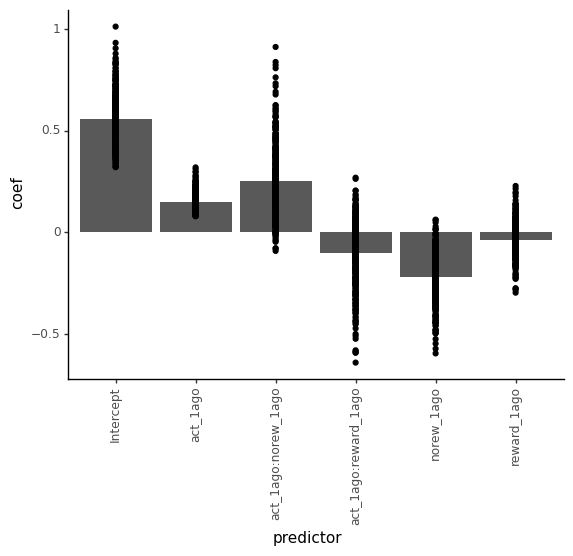

<ggplot: (120395065495)>

In [24]:
# TODO: R^2
g = (gg.ggplot(all_model_results, gg.aes('predictor', 'coef'))
     + gg.stat_summary(geom='bar')
     + gg.geom_point()
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
    )
g

In [ ]:
all_model_results_raw

In [ ]:
# Add measures as column
all_model_results = all_model_results_raw.reset_index(
    ).rename(columns={'index': 'predictor'})

# Add general predictor columns
all_model_results['pred'] = all_model_results.predictor.apply(lambda x : x[:5])
all_model_results['n_ago'] = all_model_results.predictor.apply(lambda x : np.nan if (len(x) < 4) or (x[-4] in ['c', 'u']) else int(x[-4]))

# Add sigmoid columns
all_model_results = all_model_results.loc[(all_model_results.coef > -200) & (all_model_results.coef < 200)]  # exclude crazy values
all_model_results['sig_coef'] = sigmoid(all_model_results.coef)

# Add animal columns
all_model_results['sex'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
all_model_results['agegroup'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
all_model_results['age'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'age'))
all_model_results['animal'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'animal'))

for ani in np.unique(all_model_results.animal):
    all_model_results.loc[all_model_results.animal == ani, 'session'] = get_session(
        all_model_results.loc[all_model_results.animal == ani])  # needs to be within loops over animals
all_model_results['meta'] = add_meta_column(all_model_results)  # needs session column

# Check it out
all_model_results[:30]

In [ ]:
# Save as csv
all_model_results.to_csv(os.path.join(mouse_data_dir, 'all_model_results.csv'))

In [ ]:
# Check out sigmoided coefficients
gg.options.figure_size = (5, 5)
g = (gg.ggplot(all_model_results, gg.aes('coef', 'sig_coef', color='predictor'))
     + gg.geom_point(size=0.5)
     + gg.coord_cartesian(ylim=(0, 1))
    )
g

In [ ]:
# Plot coefficients
g = (gg.ggplot(all_model_results, gg.aes('-n_ago', 'sig_coef', color='pred'))
#      + gg.geom_point(position='jitter', alpha=0.3, size=0.3)
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.geom_hline(yintercept=0.5, linetype='dotted')
     + gg.facet_grid('agegroup ~ sex')
    )
g.save(os.path.join(plot_dir, '5_regression_sig_coefs.png'))
g

In [ ]:
g2 = g + gg.aes(y='coef') + gg.geom_hline(yintercept=0, linetype='dotted')
g2.save(os.path.join(plot_dir, '5_regression_coefs.png'))
g2

### Understanding why

In [ ]:
# Making sure everything is coded right:
    # no reward + left (0.0)  => norew -1, reward 0
    # no reward + right (1.0) => norew +1, reward 0
    #    reward + left (0.0)  => reward -1, norew 0
    #    reward + right (1.0) => reward +1, norew 0
true_dat.loc[:30, ['fullID', 'trial', 'reward', 'action', 'reward_1ago', 'norew_1ago', 'stay_1ago', 'stay_2ago', 'switch_1ago']]

In [ ]:
gg.options.figure_size = (1, 1)
sub_dat = true_dat.loc[true_dat.rt < 0.5]

for ago in range(1, 10):
    
    # Reward effect looks good: Mice choose left after left-reward, and right after right-reward
    gr = (gg.ggplot(sub_dat, gg.aes('reward_{}ago'.format(ago), 'action'))
         + gg.stat_summary()
         + gg.theme(legend_position='none')
         + gg.geom_hline(yintercept=0, linetype='dotted')
#          + gg.geom_hline(yintercept=1, linetype='dotted')
    )
    print(gr)

    # No reward effect looks wrong: Mice choose left after left-NO reward, and right after right-NO reward
    gn = gr + gg.aes('norew_{}ago'.format(ago))
    print(gn)

#     # Stay looks a little skewed too: Mice repeat right more than left
#     gs = gr + gg.aes('stay_{}ago'.format(ago))
#     print(gs)

gg.options.figure_size = (5, 5)

In [ ]:
gg.options.figure_size = (1, 1)

# Reward effect looks good: Mice choose left after left-reward, and right after right-reward
gr = (gg.ggplot(true_dat, gg.aes('factor(action)', 'reward_1ago'))
     + gg.stat_summary()
     + gg.theme(legend_position='none')
     + gg.labs(x='left right', y='left <-reward-> right')
)
print(gr)

# No reward effect looks wrong: Mice choose left after left-NO reward, and right after right-NO reward
gn = gr + gg.aes(y='norew_1ago')
print(gn)

# Stay looks a little skewed too: Mice repeat right more than left
gs = gr + gg.aes(y='stay_1ago')
print(gs)

gg.options.figure_size = (5, 5)

# OLD

In [ ]:
true_dat['session2'] = 2 * np.round(true_dat.session / 2)
true_dat['session3'] = 3 * np.round(true_dat.session / 3)
sub = true_dat[(true_dat.agegroup == "Juvenile")]
g = (gg.ggplot(sub, gg.aes('age', 'correct', color='factor(session)', group='factor(session)'))
     + gg.stat_summary()
     + gg.stat_summary(geom="line")
     + gg.facet_grid('~ gender')
    )
g

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high) * (true_dat.meta == '1-3')
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
    mean_dat,
).fit().summary())

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high)
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
#     "correct ~ gender + trials2switch + session + agegroup + session:agegroup + trials2switch:session:agegroup + trials2switch:session",
    mean_dat,
).fit().summary())

In [ ]:
# Age group difference in early sessions?
low, hig = 1, 6
sub_dat_t = true_dat[(true_dat.meta == '0-2') * (true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session + agegroup) * (trials2switch + gender + session + agegroup)",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

# Do adults do more meta-learning than juveniles?
sub_dat_t = true_dat[(true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session) * (trials2switch + gender + session) * agegroup",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

In [ ]:
import numpy as np                                                                                         
import statsmodels.api as sm                                                                               
import pandas as pd                                                                                        
                                                                                                           
# create fake data                                                                                         
# y: binary response                                                                                       
# x: continuous predictor                                                                                  
# re: three class random intercepts                                                                        
fakedata = pd.DataFrame({'y' : np.random.sample(50).round(),                                               
                         'x' : np.random.sample(50),                                                       
                         're' : (np.random.sample(50)*2).round().astype(int).astype(str)})
                                                          
# this is implemented as I understand the doc:                                                             
binom_model = sm.BinomialBayesMixedGLM(                                                                    
                                       fakedata['y'], # endog                                              
                                       fakedata['x'][:, None], # exog                                      
                                       pd.get_dummies(fakedata['re']), # Array of covariates for the random
                                       np.r_[0, 0, 0]) # ident, columns of exog_vc                         
binom_result = binom_model.fit_vb()
print(binom_result.summary())

In [ ]:
fakedata

In [ ]:
import numpy as np                                                                                                              
import pandas as pd                                                                                                             
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM, BinomialBayesMixedGLM                                      
                                                                                                                                
n = 1000                                                                                                                        
m = 50 # Number of groups                                                                                                       
grp = np.random.randint(0, m, n)                                                                                                
grp_efx = np.random.normal(size=m)                                                                                              
n_relapse_xmt = np.random.normal(size=n)                                                                                        
lpr = grp_efx[grp] + n_relapse_xmt                                                                                              
mn = np.exp(lpr)                                                                                                                
total_days_AU_MS = np.random.poisson(mn)                                                                                        
X = pd.DataFrame({"total_days_AU_MS": total_days_AU_MS,                                                                         
                  "f_id_site": grp,                                                                                             
                  "n_relapse_xmt": n_relapse_xmt})                                                                              
                                                                                                                                
formula = 'total_days_AU_MS ~ 1 + n_relapse_xmt'                                                                                
                                                                                                                                
glm_model = PoissonBayesMixedGLM.from_formula(formula=formula,                                                                  
                vc_formulas={'f_id_site': '0 + C(f_id_site)'}, data=X)                                                          
glm_results = glm_model.fit_map()                                                                                               
print(glm_results.summary())  

In [ ]:
print(smf.mixedlm(
    "correct ~ (agegroup + session + gender) * (agegroup + session + gender)",
    sub_dat,
    groups=sub_dat.animal
).fit().summary())

In [ ]:
# PC_sim_dir = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat"

In [ ]:
# # Define simulations to be analzed
# n_agents = 100
# PC_sim_name = [f for f in os.listdir(PC_sim_dir) if ('.csv' in f) and ('params' in f)]
# model_names = [modelname.split('_')[1] for modelname in modelnames]
# print(model_names)

In [ ]:

# simulation_dir = os.path.join(PC_sim_dir, 'PC_{}_*.csv'.format(model_name, n_agents))
# if save_or_load_sim_mouse_dat == 'save':
#     sim_dat = pd.read_csv(simulation_dir)
#     sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
# else:
#     sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
# sim_dat = add_meta_column(sim_dat)
# sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))

# # Plot simulated data
# print("Plotting...")
# make_trials2switch_plot(sim_dat, suf='sim' + model_name)
# make_12ago_plot(sim_dat, 'sim' + model_name)
# make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
# make_block_correct_plot(sim_dat, 'sim' + model_name)
# make_session_correct_plot(sim_dat, 'sim' + model_name)
# make_age_reward_plot(sim_dat, 'sim' + model_name)

In [ ]:

# # model_names = [ 'Bbspr', 'Bbp', 'Bbpr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']

# # Read in and format simulated data
# # for PC_sim_name in PC_sim_names:
#     print("Model {}".format(model_name))
#     simulation_dir = os.path.join(PC_sim_dir, 'simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
#     if save_or_load_sim_mouse_dat == 'save':
#         sim_dat = pd.read_csv(simulation_dir)
#         sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
#     else:
#         sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
#     sim_dat = add_meta_column(sim_dat)
#     sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))
    
#     # Plot simulated data
#     print("Plotting...")
#     make_trials2switch_plot(sim_dat, suf='sim' + model_name)
#     make_12ago_plot(sim_dat, 'sim' + model_name)
#     make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
#     make_block_correct_plot(sim_dat, 'sim' + model_name)
#     make_session_correct_plot(sim_dat, 'sim' + model_name)
#     make_age_reward_plot(sim_dat, 'sim' + model_name)